### 観測データ
解析に必要なデータ
- XFFTS data
- Encoder data
- weather status
- hosei copy
- obs copy


### 解析フロー

- doppler tracking
- Chopper Wheel
- baseline fitting
- Scaling(from standard object?)
- regrid
    - rms
    - distance
- +header
- 3d-fits

あらかじめxfftsの分光データをra,dec対応させておく

In [ ]:
#radec 変換データ作成
#! python analy_coordinates.py

In [ ]:
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import numba
###以下独自
import n2df
import read_obsfile
import doppler_nanten


In [70]:
###AzEl情報をradecに変換したものの一時ファイルの読み込み
path_to_xffts_c = "./xffts_radec0807.npy"
path_to_encoder_c = "./encoder_radec0807.npy"
xffts = numpy.load(path_to_xffts_c)
encoder = numpy.load(path_to_encoder_c)

In [71]:
###-30 == 330deg なので。この辺どうしようかね？
#xffts[0] = xffts[0]-360

### gridの作成


In [72]:
#観測プログラムから必要な情報を出す
obsfile_dict = read_obsfile.read("./otf_test3_n31.obs")
lamda_on = obsfile_dict["lambda_on"]
beta_on = obsfile_dict["beta_on"]
N = obsfile_dict["N"]
grid = obsfile_dict["grid"]/3600 #[deg]

In [73]:
#今回girdからどこまで離れた範囲まで解析の中に含めるかの値。これは外からいじれる値にしておかないと
offset = 10#[arcsec]
array_num = 2#1~16IF 

In [74]:
#make gird
ragrid = numpy.arange(lamda_on - ((N-1)/2)*grid, lamda_on + ((N-1)/2+1)*grid, grid)
decgrid = numpy.arange(beta_on - ((N-1)/2)*grid, beta_on + ((N-1)/2+1)*grid, grid)
radec_grid = numpy.meshgrid(ragrid, decgrid)

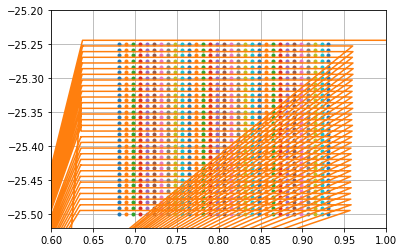

In [75]:
#gridの確認
#girdとXFFTSの点がずれている。これはプロジェクションの問題でcosがかかっていないからか？
plt.plot(radec_grid[0], radec_grid[1], ".")
plt.plot(xffts[0], xffts[1])
#plt.plot(encoder[0], encoder[1],".")
plt.xlim(0.6,1)
plt.ylim(-25.52, -25.2)
plt.savefig("neko.pdf")
plt.grid()
plt.show()

## doppler tracking

## Chopper Wheel 

In [77]:
%%time
n = n2df.Read("/home/amigos/ros/src/necst/scripts/record/hdd/otf20190807_n31.n2df")
#データ読み出し（観測モードとscan番号）
obs_mode = n.read_obs_mode()
scan_num = n.read_scan_num()
array_data = n.read_onearray(array_num)
###array_data, scan_num, obs_mode = n.read_for_otf(1)#3分くらいかかっちゃった

100%|██████████| 9399/9399 [01:23<00:00, 112.43it/s]


CPU times: user 1.96 s, sys: 2.17 s, total: 4.13 s
Wall time: 1min 24s


In [78]:
###index探し
obs_mode = numpy.array(obs_mode)
scan_num = numpy.array(scan_num)

offmask = obs_mode == "OFF"
offindex = numpy.where(offmask == True)

hotmask = obs_mode == "HOT"
hotindex = numpy.where(hotmask == True)

onmask = obs_mode == "ON"
onindex = numpy.where(onmask == True)

max_scannum = numpy.max(scan_num)#Caution! scan num starts from 0, so scan number of 26 indicates 27 times scan

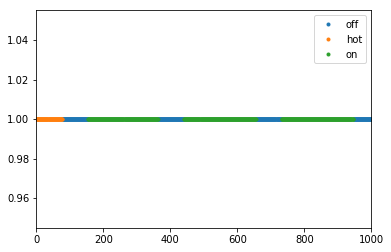

In [80]:
#一応indexの可視化
plt.plot(offindex[0], [1]*len(offindex[0]),"." , label = "off")
plt.plot(hotindex[0], [1]*len(hotindex[0]),"." , label = "hot")
plt.plot(onindex[0], [1]*len(onindex[0]),"." , label = "on")
plt.xlim(0,1000)
plt.legend()
plt.show()

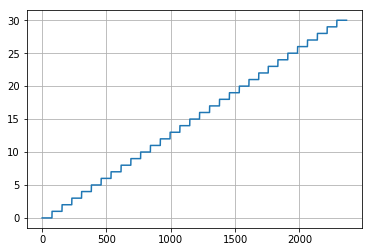

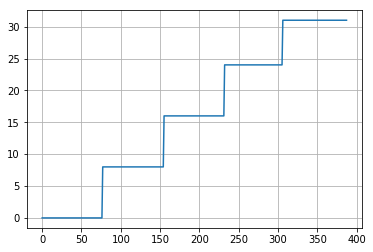

In [102]:
#OFF 点のscan number を取得
scan_num = numpy.array(scan_num)
offindex[0]
plt.plot(scan_num[offindex[0]])
plt.grid()
plt.show()

#OFF 点のscan number を取得
scan_num = numpy.array(scan_num)
hotindex[0]
plt.plot(scan_num[hotindex[0]])
plt.grid()
plt.show()

In [122]:
#HOT積分（new version）
print(numpy.unique(scan_num[hotindex[0]]))#HOT のscan number
hotnum = numpy.unique(scan_num[hotindex[0]])#HOTの数

hotdata = []

for i in tqdm(hotnum):#i = scan number
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], hotindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]
    ###
    mm = index[0][c]#scan numの値でフィルターしたhot
    #print(mm)
    ###積分
    tmp = [array_data[j] for j in mm]
    hotdata.append(sum(tmp)/len(tmp))
    pass



  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 462.17it/s]

[ 0  8 16 24 31]


In [158]:
d = numpy.unique(scan_num[hotindex[0]])#HOT のscan number
hotdata_ = []
count = -1

for i in tqdm(range(max_scannum+1)):
    if i in d:
        count += 1
    hotdata_.append(hotdata[count])

h



  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:00<00:00, 12398.87it/s]

In [142]:
# %%time
# import time
# ##hotの積分
# hotdata = []

# scan_num = numpy.array(scan_num)

# for i in tqdm(range(max_scannum+1)):
#     st0 = time.time()
#     mask = scan_num == i#特定のscannumのindexを抜き出す
#     index = numpy.where(mask == True)#特定のscannumのindex変数
#    ### 
#     c = numpy.in1d(index[0], hotindex[0])#特定のscannumのindex&HOT index
#     c = numpy.where(c == True)[0]#scannumとhotで絞ったindex
#     mm = index[0][c]#scan numの値でフィルターしたhot
#     st1 = time.time()
#     tmp = [array_data[j] for j in mm]
#     st2 = time.time()
#     hotdata.append(sum(tmp)/len(tmp))

In [82]:
%%time
##OFFの積分
offdata = []
scan_num = numpy.array(scan_num)

for i in tqdm(range(max_scannum+1)):
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], offindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]#scannumとhotで絞ったindex
    mm = index[0][c]#scan numの値でフィルターしたhot
    tmp = [array_data[j] for j in mm]
    offdata.append(sum(tmp)/len(tmp))

  0%|          | 0/32 [00:00<?, ?it/s]


ZeroDivisionError: division by zero

In [83]:
# ###Choper wheel
# #Taslist = (ONlist - OFFlist)/(HOTlist - OFFlist) * 300

@numba.jit
def chopper_wheel(on_index, scan_num, temprature = 300):
    #scan_num = n[on_index]["scan_num"]
    Tastar = (array_data[on_index] - offdata[scan_num])/(hotdata[scan_num] - offdata[scan_num]) * temprature
    #Tastar = (array_data[on_index] - offdata[0])/(hotdata[0] - offdata[0]) * temprature#just test will be deleted
    return Tastar

def calc(i):#on点をscan indexでmaskしchopper wheelする
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
    #c = numpy.in1d(index[0], onindex[0])#特定のscannumのindex&ON index
    #c = numpy.where(c == True)[0]#scannumとhotで絞ったindex
    c = numpy.intersect1d(index[0], onindex[0])
    #return [(index[0][j], chopper_wheel(index[0][j], i)) for j in c]
    return [[j, chopper_wheel(j, i)] for j in c]

In [84]:
ondata = [calc(i) for i in tqdm(range(max_scannum+1))]

  3%|▎         | 1/32 [00:05<02:58,  5.77s/it]

IndexError: list index out of range

In [ ]:
%%time
# for i in range(len(ondata)):
#     for j in range(len(ondata[i])):
#         print(ondata[i][j][0], end=" ")
data_on = {ondata[i][j][0]:ondata[i][j][1] for i in range(len(ondata)) for j in range(len(ondata[i]))}###d[onindex] = onarray
#print(data_on.keys())

In [ ]:
#距離計算関数作成
def gauss(x, a = 1, mu = 0, sigma = 30):
    return a * numpy.exp(-(x - mu)**2 / (2*sigma**2))

def calc_distance(d1, d2):
    #d1 = [ra, dec] #deg   
    factor = 3600
    d1[0] = d1[0]*3600
    d1[1] = d1[1]*3600
    d2[0] = d2[0]*3600
    d2[1] = d2[1]*3600
    return gauss(((d1[0] - d2[0])**2 + (d1[1] - d2[1])**2)**0.5)



In [ ]:
gauss(3)

## Baseline fitting

In [20]:
# option

# for baseline fitting to avoid spurious 
mi = int(5000)
ma = int(15000) 
width = int(500)

# integration range
integ_mi = int(8000)
integ_ma = int(9000)


## grid内のデータ探索

In [21]:
%time
index_list = []
for i in tqdm(range(31)):
    for j in range(31):
       # print(ragrid[i], decgrid[j])
        index1 = numpy.where((ragrid[i]-(offset/3600)<xffts[0]) & ((ragrid[i] + (offset/3600)>xffts[0])))
        index2 = numpy.where((decgrid[j]-(offset/3600)<xffts[1]) & ((decgrid[j] + (offset/3600)>xffts[1])))
        index_ = [i in index2[0] for i in index1[0]]
        index_ = numpy.array(index_)
        index_1and2 = numpy.where(index_ == True)
        index_1and2 = index1[0][index_1and2]
        index_list.append(index_1and2)


100%|██████████| 31/31 [00:00<00:00, 421.42it/s]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.34 µs


In [22]:
#print(index_list)###どこのgridには何のindexのデータを含めるかというindex

In [23]:
#どこのデータまでがあるgridのデータかというやつ
# %matplotlib notebook
# for i in index_list[4:5]:
#     plt.plot(xffts_ra[i], xffts[1][i], ".", alpha = 0.5)
# plt.plot(xffts_ra, xffts[1], ".", alpha = 0.1)
# plt.xlim(-31,-30.6)
# plt.ylim(-25.23, -25.52)
# plt.grid()
# plt.show()

### xfftsデータの確認

### データをgridに入れる

本番はもう少し賢く書くけど、ひとまず

In [24]:
516 in onindex[0]
data_on[516]

array([ -879.49176,  -462.7745 , -1591.1285 , ..., -1311.861  ,
        3376.5835 ,   -92.54552], dtype=float32)

In [25]:
%%time
#cubeデータの作成
data_c = numpy.zeros((31, 31, 32768))#ra dec ch
index_list2 = numpy.reshape(index_list, (31,31))#index listの2次元化（これは前処理しておく） #これは正しいか？

## Chopper wheelしたデータ入れる（baseline fit 忘れている）
for i in tqdm(range(31)):#ra
    for j in range(31):#dec
        try:
            sum_list = []
            for k in index_list2[i][j]:
                dist = calc_distance([ragrid[i], decgrid[j]], [xffts[0][k], xffts[1][k]])
                print(dist)
                sum_list.append(data_on[k]/dist**2)
                #data_c[i][j] = sum([data_on[k] for k in index_list2[i][j]])/len(index_list2[i][j])#data cubeにデータを格納
            data_c[i][j] = sum(sum_list)/len(sum_list)
        except Exception as e:
            print("[{},{}], {}".format(i,j,e), end = "")

  0%|          | 0/31 [00:00<?, ?it/s]

0.9620629261740069
0.9989053452727399
0.9972586171077813
0.9821860708802144
0.9739030000991803
0.9883354994439214
0.9919356237297158
0.9938014395352969
0.985266596642563
0.998912858610239
0.9975533962857116
0.9833795261190562
0.9891512031046151
0.9787839322735511
[0,14], division by zero[0,15], division by zero[0,16], division by zero[0,17], division by zero[0,18], division by zero[0,19], division by zero[0,20], division by zero[0,21], division by zero[0,22], division by zero[0,23], division by zero[0,24], division by zero[0,25], division by zero[0,26], division by zero[0,27], division by zero[0,28], division by zero[0,29], division by zero[0,30], division by zero0.9993625890601009
[1,1], division by zero0.9713644069408145
0.9819555731797167
0.9975169392737119
0.979065372406986
0.9846544102402142
0.9785081048875033
0.981974073184104
0.9739166919182356
0.9718775399251437
0.9835014848729533
0.9799098062515273
0.9940439197447797
[1,14], division by zero[1,15], division by zero[1,16], divi

 68%|██████▊   | 21/31 [00:00<00:00, 169.30it/s]

0.9915738554404881
0.9933652773719764
0.9986711830507837
0.9656841558163606
0.9514877110484135
0.9580777985257788
0.9492382501631601
0.9840619978936613
0.9481296158848224
0.9955156800791989
0.9980225522306072
[20,14], division by zero[20,15], division by zero[20,16], division by zero[20,17], division by zero[20,18], division by zero[20,19], division by zero[20,20], division by zero[20,21], division by zero[20,22], division by zero[20,23], division by zero[20,24], division by zero[20,25], division by zero[20,26], division by zero[20,27], division by zero[20,28], division by zero[20,29], division by zero[20,30], division by zero0.9879864750723848
0.9650938999766292
0.9778731519216008
0.9776143855547592
0.9779330921461622
0.9743551160756826
0.9990599353985999
0.9985929455765423
0.9929022060718263
0.9989406039055886
0.9902784009792008
0.9997671428145083
0.9849243933063299
0.9642613870828276
[21,14], division by zero[21,15], division by zero[21,16], division by zero[21,17], division by zero

 90%|█████████ | 28/31 [00:00<00:00, 113.13it/s]

0.9915202142409525
0.9958847328961299
0.9731047491238556
0.9876812641012287
0.9868541567756168
0.999678970303049
0.9901419678133369
0.9983908945944967
0.9840124665194808
[27,14], division by zero[27,15], division by zero[27,16], division by zero[27,17], division by zero[27,18], division by zero[27,19], division by zero[27,20], division by zero[27,21], division by zero[27,22], division by zero[27,23], division by zero[27,24], division by zero[27,25], division by zero[27,26], division by zero[27,27], division by zero[27,28], division by zero[27,29], division by zero[27,30], division by zero0.9966095845939169
0.9977078280949384
0.9649681340963048
0.9653956084184987
0.9996381743569567
0.9743925774135411
0.969200685554185
0.9961810173575988
0.9876483715259207
0.987212879996861
0.954898035964892
0.9770486788584267
0.9674263574930496
0.9796731737983242
[28,14], division by zero[28,15], division by zero[28,16], division by zero[28,17], division by zero[28,18], division by zero[28,19], division

100%|██████████| 31/31 [00:00<00:00, 116.03it/s]

0.9954985496120987
0.9976397474747339
0.9575426126653019
0.9720744904023129
0.9743038549929027
0.9984452343799786
0.9923031533826061
0.9804383669241086
0.9946192163315678
[29,14], division by zero[29,15], division by zero[29,16], division by zero[29,17], division by zero[29,18], division by zero[29,19], division by zero[29,20], division by zero[29,21], division by zero[29,22], division by zero[29,23], division by zero[29,24], division by zero[29,25], division by zero[29,26], division by zero[29,27], division by zero[29,28], division by zero[29,29], division by zero[29,30], division by zero0.9984352126395255
0.9840254282639492
0.9528417204133397
0.9694482854183937
0.9994040114177111
0.9726705231234283
0.9695107231715393
0.9986246531690726
0.9919165111660474
0.9984006405822966
0.9688596328447977
0.9806980032268753
0.9885262460031075
0.966020690317464
[30,14], division by zero[30,15], division by zero[30,16], division by zero[30,17], division by zero[30,18], division by zero[30,19], divis

距離を考慮すると...

### astropyでfitsに書き出す

In [26]:
from astropy.io import fits
numpy.shape(data_c)

(31, 31, 32768)

In [27]:
#3軸の入れ替え。transposeでいい気が。。。
data_c = numpy.swapaxes(data_c, 0,2)
#data_c = numpy.swapaxes(data_c, 2,1)
print(numpy.shape(data_c))#軸の入れ替えの確認

(32768, 31, 31)


In [28]:
header_dict = {
"object" : obsfile_dict["object"],
"crval1" : obsfile_dict["lambda_on"],
"cdelt1" : obsfile_dict["grid"]/3600,
"crpix1" : obsfile_dict["N"]-1/2,#中心ピクセル
"crval2" : obsfile_dict["beta_on"],
"cdelt2" : obsfile_dict["grid"]/3600,
"crpix2" : obsfile_dict["N"]-1/2 #中心ピクセル
}

In [29]:
temp = """
SIMPLE  =                    T                                                  
BITPIX  =                  -64                                                  
NAXIS   =                    3                                                  
NAXIS1  =                  31                                                 
NAXIS2  =                  31                                                 
NAXIS3  =                   32768                                                  
OBJECT  = '{object}              '                                                  
TELESCOP= 'NANTEN2            '                                                  
INSTRUME= 'MULT2-11          '                                                  
OBSERVER= 'z7510rk           '                                                  
DATE-OBS= '2007-12-30        '                                                  
DATE-MAP= '2012-01-19        '                                                  
BSCALE  =    0.10000000000E+01                                                  
BZERO   =    0.00000000000E+01                                                  
BUNIT   = 'K                 '                                                  
EPOCH   =    0.20000000000E+04                                                  
OBSRA   =    8.38104170000E+01                                                  
OBSDEC  =   -5.37511100000E+00                                                  
DATAMAX =    1.16774444580E+02                                                  
DATAMIN =   -8.33924560547E+01                                                  
CTYPE1  = 'RA---GLS          '                                                  
CRVAL1  =    {crval1}                                                  
CDELT1  =    {cdelt1}                                                  
CRPIX1  =      {crpix1}
CROTA1  =     0.0000000000E+00                                                  
CTYPE2  = 'DEC--GLS          '                                                  
CRVAL2  =   {crval2}                                                  
CDELT2  =   {cdelt2}                                               
CRPIX2  =     {crpix2}                                               
CROTA2  =     0.0000000000E+00                                                  
CTYPE3  = 'VELO-LSR          '                                                  
CRVAL3  =    2.50000000000E+02                                                  
CDELT3  =    5.00000000000E+02                                                  
CRPIX3  =    1.00000000000E+00                                                  
CROTA3  =    0.00000000000E+00                                                  
BLANK   =   -1.00000000000E+00 """.format(**header_dict)

In [30]:
target_header = fits.Header.fromstring(temp, sep = "\n")

In [31]:
#書き出し
hdu = fits.PrimaryHDU(data_c, target_header)
hdulist = fits.HDUList([hdu])
hdulist.writeto("test2.fits", overwrite = True)

In [32]:
##読み込み
hdu_list = fits.open("test2.fits")
hdu_r = hdu_list[0]
data = hdu_r.data
header = hdu_r.header

## 以下test

In [33]:
%%time
import n2df
n = n2df.Read("/home/amigos/ros/src/necst/scripts/record/hdd/n31otf20190801.dat")
n[0]["scan_num"]

CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 10.4 ms


In [34]:
%time
n[6000]["scan_num"]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs


17

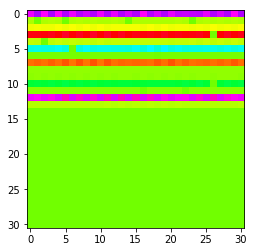

In [35]:
%matplotlib inline
i = 12309
plt.imshow(data_c[i], cmap = "gist_rainbow")
plt.show()


In [36]:
plt.show()

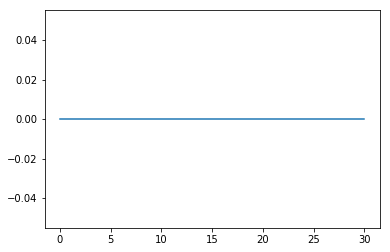

In [37]:
tnum = 3000
plt.plot(data_c[tnum][18])
plt.show()

In [38]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   31                                                  
NAXIS2  =                   31                                                  
NAXIS3  =                32768                                                  
                                                                                
OBJECT  = 'OriKL              '                                                 
                                                                                
TELESCOP= 'NANTEN2            '                                                 
                                                                                
INSTRUME= 'MULT2-11          '                                                  
OBSERVER= 'z7510rk          

In [39]:
#変なピークが見られるが、これはなんだ？？？
%matplotlib inline
tnum= 4101
plt.grid()
plt.plot(data_c[tnum][３1])
plt.show()

for i in range(30):
    print(i,"  ", max(abs(data_c[tnum][i])))

SyntaxError: invalid character in identifier (<ipython-input-39-910f2beee52e>, line 5)

In [ ]:
obsfile_dict

In [4]:
dn = doppler_nanten.doppler_nanten()
import numpy
xffts[0] = numpy.deg2rad(xffts[0])
xffts[1] = numpy.deg2rad(xffts[1])

In [6]:
%%time 
for i, j ,k in tqdm(zip(xffts[0], xffts[1], xffts[2])):
    dd = dn.calc_vobs(i, j, k)

4367it [05:54, 12.31it/s]

CPU times: user 6min 14s, sys: 4.18 s, total: 6min 19s
Wall time: 5min 54s


In [7]:
len(xffts[1])

4367